### Installing dependencies


In [ ]:
!pip install -q flwr[simulation] flwr_datasets[vision] torch torchvision matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.7/364.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.1 MB/s eta 0:00:00
ERROR: pip's dependen

# **IMPORTING ESSENTIAL LIBRARIES**

In [ ]:
from collections import OrderedDict
from typing import List, Tuple, Dict

import matplotlib.pyplot as plt
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, random_split
from torchvision.transforms import ToTensor, Normalize, Compose, RandomHorizontalFlip, RandomRotation
from torchvision.datasets import CIFAR10


from datasets.utils.logging import disable_progress_bar

import xml.etree.ElementTree as ET
import flwr as fl
from flwr.common import Metrics
from flwr_datasets import FederatedDataset


## Run on CPU
DEVICE = torch.device("cpu")



# **PREPARING IID DATASET**


In [ ]:

cfg = {'num_rounds': 5, 'num_clients': 10,
       'batch_size': 32, 'num_clients_per_round_fit':2,
       'num_clients_per_round_eval':2,
       'config_fit': {'lr': 0.01, 'momentum': 0.9, 'local_epochs' : 1}}
NUM_CLIENTS = 10
BATCH_SIZE = 32


def load_datasets():
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": cfg.get('num_clients')})


    trainloaders = []
    valloaders = []
    for partition_id in range(cfg.get('num_clients')):
        partition = fds.load_partition(partition_id, "train")
        partition = partition.with_transform(transform_train)
        partition = partition.train_test_split(train_size=0.8, seed=42)
        trainloaders.append(DataLoader(partition["train"], batch_size=cfg.get('batch_size')))
        valloaders.append(DataLoader(partition["test"], batch_size=cfg.get('batch_size')))
    testset = fds.load_split("test").with_transform(transform_test)
    testloader = DataLoader(testset, batch_size=cfg.get('batch_size'))
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


KeyboardInterrupt: 

# **PREPARING NON-IID DATASET**
***CLASS VERSION***

In [ ]:
def parse_xml_assignments(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    node_assignments = {}
    for node in root.findall('Node'):
        node_id = int(node.get('id'))
        shards = [(int(dp.get('classLabel')), int(dp.get('shard'))) for dp in node.findall('DataPair')]
        node_assignments[node_id] = shards
    return node_assignments

from google.colab import files
uploaded = files.upload()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Saving shards.xml to shards.xml


In [ ]:
class Dataset:
  def __init__(self):
    self.num_classes = 10
    self.num_shards_per_class = 10
    self.transform = Compose([
      ToTensor(),
      Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
      ])

  def load_CIFAR10_dataset(self):
    train = CIFAR10(root= './data', train= True, download= True, transform= self.transform)
    test = CIFAR10(root= './data', train= False, download= True, transform= self.transform)
    return train, test

  def divide_class_into_shards(self, dataset, num_classes: int, num_shards_per_class: int):
    num_shards = num_classes * num_shards_per_class
    num_imgs = int(len(dataset)/ num_shards_per_class / num_classes)
    ## Create a list to store indices for each class
    class_indices = [[] for _ in range(num_classes)]
    labels = np.array(dataset.targets)

    # Group the indices of each class
    for idx, label in enumerate(labels):
      class_indices[label].append(idx)

    # Shuffle indices within each class

    for i in range(num_classes):
      np.random.shuffle(class_indices[i])

    shards = []
    for i in range(num_classes):
      for j in range(num_shards_per_class):
        shards.append(class_indices[i][j*num_imgs:(j+1)*num_imgs])
    shards = np.array(shards)
    return shards, num_shards

  def load_shards_from_xml_file(self, xml_file, train, test, num_clients):
    node_assignments = parse_xml_assignments(xml_file)
    train_data_indices = {i: np.array([], dtype='int64') for i in range(num_clients)}
    test_data_indices = {i: np.array([], dtype='int64') for i in range(num_clients)}
    train_shards, _ = self.divide_class_into_shards(train, 10, 20)
    test_shards, _ = self.divide_class_into_shards(test, 10, 20)
    trainLoaders = []
    testLoaders = []
    for node in range(num_clients):
      shard_ids = node_assignments[node]
      print(shard_ids, "ids")
      indices_tr = [(shard_id[0] - 1) * 20 + shard_id[1] for shard_id in shard_ids]
      indices_ts = [(shard_id[0] - 1) * 20 + random.randint(1,19) for shard_id in shard_ids]
      print("done")
      train_indices = np.concatenate([train_shards[idx] for idx in indices_tr])
      test_indices = np.concatenate([test_shards[idx] for idx in indices_ts])
      train_loader = DataLoader(Subset(train, train_indices), batch_size=64, shuffle=True)
      trainLoaders.append(train_loader)
      test_loader = DataLoader(Subset(test, test_indices), batch_size=64, shuffle=True)
      testLoaders.append(test_loader)

    return trainLoaders, testLoaders
  def noniid_split(self, dataset, num_classes: int, num_clients: int, num_shards_per_class: int):

    shards, num_shards = self.divide_class_into_shards(dataset, num_classes, num_shards_per_class)
    ## Ensure each client gets 2 shards from different classes
    client_data_indices = {i: np.array([], dtype='int64') for i in range(num_clients)}
    shards_per_client = 4
    shards_assignments = np.zeros(num_shards, dtype=bool)
    classes = []
    for client in range(num_clients):
      assigned_shards = []
      classes_assigned = []

      while len(assigned_shards) < shards_per_client:
        shard_idx = np.random.choice(np.where(shards_assignments == False)[0])
        class_idx = shard_idx // num_shards_per_class
        if class_idx not in classes_assigned:
          assigned_shards.append(shard_idx)
          classes_assigned.append(class_idx)
          shards_assignments[shard_idx] = True

      classes.append(classes_assigned)
      print(classes_assigned)

      for shard in assigned_shards:
        print("in shatd")
        client_data_indices[client] = np.concatenate((client_data_indices[client], shards[shard]), axis=0)
    return client_data_indices, classes
  def partition_test_data_based_on_train(self, dataset, train_idx, num_classes: int, num_clients: int, num_shards_per_class: int):

    shards, num_shards = self.divide_class_into_shards(dataset, num_classes, num_shards_per_class)
    ## Ensure each client gets 2 shards from different classes
    client_data_indices = {i: np.array([], dtype='int64') for i in range(num_clients)}
    shards_per_client = 4
    shards_assignments = np.zeros(num_shards, dtype=bool)
    classes = []
    for client in range(num_clients):
      assigned_shards = []
      classes_assigned = []

      while len(assigned_shards) < shards_per_client:
        class_idx = train_idx[client][len(assigned_shards)]
        #shard_idx = np.random.choice(np.where(shards_assignments == False)[0])
        shard_idx = (class_idx * 20) + random.randint(1,19)
        #if class_idx not in classes_assigned:
        assigned_shards.append(shard_idx)
        classes_assigned.append(class_idx)
          #shards_assignments[shard_idx] = True

      classes.append(classes_assigned)
      print(classes_assigned)

      for shard in assigned_shards:
        client_data_indices[client] = np.concatenate((client_data_indices[client], shards[shard]), axis=0)
    return client_data_indices
  def get_dataloaders(self, dataset, indices, batch_size= 32):
    loaders = []
    for client_idx in indices:
      subset = Subset(dataset, indices[client_idx])
      loader = DataLoader(subset, batch_size=32, shuffle= True)
      loaders.append(loader)
    return loaders

dataset = Dataset()
train_data, test_data = dataset.load_CIFAR10_dataset()
print("data", len(train_data), len(test_data))
#train_indices , train_idx = dataset.noniid_split(train_data, 10, 50, 20)
print("train")
#test_indices = dataset.partition_test_data_based_on_train(test_data, train_idx, 10, 50, 20)
print("test")
#trainloaders = dataset.get_dataloaders(train_data, train_indices)
#testloaders = dataset.get_dataloaders(test_data, test_indices)
trainloaders, testloaders = dataset.load_shards_from_xml_file("shards.xml", train_data, test_data, 10)
print("final", len(trainloaders), len(testloaders))




100%|██████████| 170498071/170498071 [00:15<00:00, 11077311.77it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
data 50000 10000
train
test
[(1, 3), (2, 11), (3, 18), (2, 5)] ids
done
[(2, 5), (3, 0), (3, 10), (1, 1)] ids
done
[(3, 13), (1, 1), (2, 8), (2, 3)] ids
done
[(2, 10), (1, 12), (3, 16), (1, 9)] ids
done
[(5, 18), (4, 17), (6, 2), (4, 18)] ids
done
[(4, 13), (6, 6), (5, 11), (6, 4)] ids
done
[(6, 17), (5, 4), (4, 7), (5, 11)] ids
done
[(10, 17), (8, 12), (9, 2), (7, 16)] ids
done
[(9, 19), (8, 0), (9, 5), (7, 15)] ids
done
[(8, 9), (9, 14), (10, 7), (7, 13)] ids
done
final 10 10


In [ ]:
# Transforming test and train data for CIFAR10 dataset
transform_train = Compose([
      RandomHorizontalFlip(),
      RandomRotation(10),
      ToTensor(),
      Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
      ])
transform_test = Compose([
      ToTensor(),
      Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
      ])
def set_transform(batch):
  batch["img"] = [transform_test(img) for img in batch["img"]]
  return batch

# **DEFINE THE MODEL**

In [ ]:
import torchvision.models as models

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        # Load a pre-trained ResNet18 model
        self.resnet18 = models.resnet18(pretrained=False)

        # Replace the fully connected layer to match the number of classes
        self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet18(x)

In [ ]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

# **DEFINE THE CLIENT CLASS**

In [ ]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, testloader):
        self.net = net
        self.trainloader = trainloader
        self.testloader = testloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.testloader)
        return float(loss), len(self.testloader), {"accuracy": float(accuracy)}

# **GENERATE CLIENTS**

In [ ]:

def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""
    return FlowerClient(net = Net().to(DEVICE),
                        trainloader = trainloaders[int(cid)],
                        testloader = testloaders[int(cid)]).to_client()

# **FEDERATED LEARNING**

In [ ]:




strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
      # Sample 50% of available clients for evaluation**
    min_fit_clients=50,  # Never sample less than 10 clients for training
    min_evaluate_clients=25,  # Never sample less than 5 clients for evaluation
    min_available_clients=50,  # Wait until all 10 clients are available
)

# Specify the resources each of your clients need. By default, each
# client will be allocated 1x CPU and 0x GPUs
client_resources = {"num_cpus": 1, "num_gpus": 0.0}
if DEVICE.type == "cuda":
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=50,
    config=fl.server.ServerConfig(num_rounds=1),
    strategy=strategy,
    client_resources=client_resources,
)

INFO :      Starting Flower simulation, config: num_rounds=1, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-06-13 08:08:17,697	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'CPU': 2.0, 'memory': 8005329716.0, 'object_store_memory': 4002664857.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=1708) 2024-06-13 08:08:26.725701: E external/local

History (loss, distributed):
	round 1: 0.07950439410209657

In [ ]:
def get_evaluate_fn(testloader):

    def evaluate_fn(server_round: int, parameters, config):

        model = Net()
        # set parameters to the model
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)
        # call test
        loss, accuracy = test(
            model, testloader
        )  # <-------------------------- calls the `test` function, just what we did in the centralised setting
        return {"loss": loss}, {"accuracy": accuracy}

    return evaluate_fn

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
client_resources = {"num_cpus": 1, "num_gpus": 0.0}
if DEVICE.type == "cuda":
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.
dataset = Dataset()
train_data, test_data = dataset.load_CIFAR10_dataset()
testloader = DataLoader(test_data, batch_size=128)
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    #fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,
    evaluate_fn=get_evaluate_fn(testloader),
)

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

Files already downloaded and verified
Files already downloaded and verified


INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-06-21 12:48:45,383	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 4021914009.0, 'memory': 8043828020.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=3864) 2024-06-21 12:48:51.833060: E external/local

# **PLOT ACCURACY & LOSS**

history.metrics_centralized = {'accuracy': [(0, 0.0999), (1, 0.1), (2, 0.1), (3, 0.1421), (4, 0.1474), (5, 0.1675)]}
[1.8217692899703979, 1.8806333589553834, 1.9606520628929136, 1.8852365946769714, 1.9047117972373961, 1.8345305633544922]


Text(0.5, 1.0, 'CIFAR10 - NON-IID - 50 clients with 50 clients per round')

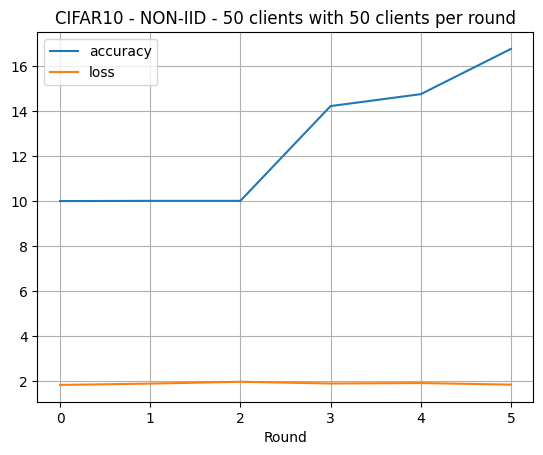

In [ ]:
import matplotlib.pyplot as plt
print(f"{history.metrics_centralized = }")

global_accuracy_centralised = history.metrics_centralized["accuracy"]
global_loss = [100.0 * (history.losses_centralized[i][1]["loss"]) for i in range(len(history.losses_centralized))]
print(global_loss)
round = [data[0] for data in global_accuracy_centralised]
acc = [100.0 * data[1] for data in global_accuracy_centralised]
plt.plot(acc, label = "accuracy")
plt.plot(global_loss, label = "loss")
plt.grid()
plt.xlabel("Round")
plt.legend()
plt.title("CIFAR10 - NON-IID - 50 clients with 50 clients per round")

In [ ]:
import csv
import os
import xml.etree.ElementTree as ET
from lxml import etree
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import copy
import logging
from datetime import datetime
import shutil
from torchvision.models import resnet18

Clustering_method="Mask"
Clustering_period = 2
cluster_number=3
log_path=datetime.now().strftime("%Y-%m-%d_%H-%M-%S_") + Clustering_method
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


# **PARSE .XML FILES**

In [ ]:
def parse_xml_assignments(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    node_assignments = {}
    for node in root.findall('Node'):
        node_id = int(node.get('id'))
        shards = [(int(dp.get('classLabel')), int(dp.get('shard'))) for dp in node.findall('DataPair')]
        node_assignments[node_id] = shards
    return node_assignments

def parse_clusters_from_file(filename):
    tree = ET.parse(filename)
    root = tree.getroot()

    # Initialize a dictionary to store the cluster data
    cluster_dict = {}

    # Iterate over each cluster element in the XML
    for cluster in root.findall('Cluster'):
        cluster_id = int(cluster.get('id'))
        nodes = []

        # Iterate over each node within the cluster
        for node in cluster.findall('Node'):
            node_id = int(node.get('id'))
            nodes.append(node_id)

        # Add the list of nodes to the dictionary under the cluster ID
        cluster_dict[cluster_id] = nodes

    return cluster_dict


## Begin Federated Training
from google.colab import files
uploaded1 = files.upload()
uploaded2 = files.upload()
Cluster_file_path = 'clusters.xml'
Cluster_file_path_main = 'clusters_main.xml'
shutil.copy(Cluster_file_path_main, Cluster_file_path)
import datetime;
log_file = log_path + '.log'
os.mkdir(log_path)
open(log_file, 'a').close()

Saving clusters_main.xml to clusters_main (1).xml


Saving clusters.xml to clusters (1).xml


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
from typing import Dict, List, Optional, Tuple, Union, Callable
from sklearn.metrics import pairwise_distances
from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.common.logger import log
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg, aggregate_inplace
from logging import WARNING

# **CALCULATING THE SIMILARITY DISTANCE**

In [ ]:
def normalize_distance(distances, num_clients):
        min1 = np.min(np.ma.masked_equal(distances, 0))
        max1 = np.max(np.ma.masked_equal(distances, 0))

        normal_distances = np.zeros((num_clients, num_clients))

        for i in range(num_clients):
            normal_distances[i][i] = 0
            for j in range(i+1, num_clients):
                normal_distances[i][j] = normal_distances[j][i] = (
                    distances[i][j]-min1)/(max1-min1)
            # print("after:",item, distances[item])
        return normal_distances

## Function to calculate the number of common IDs
def calculate_common_ids(arr1, arr2):
    return len(set(arr1).intersection(set(arr2)))

def ExtractDistances(sensitive_weights, mask_number, num_clients):
      similarity_matrix = np.zeros((num_clients, num_clients))
      for i in range(num_clients):
          for j in range(i + 1, num_clients):
              similarity = calculate_common_ids(
                  sensitive_weights[i], sensitive_weights[j])
              similarity_matrix[i, j] = similarity
              similarity_matrix[j, i] = similarity
          similarity_matrix[i, i] = mask_number

        # Convert similarity matrix to distance matrix
        # Note: Higher similarity means closer distance
      distances = mask_number - similarity_matrix
      normal_distances = normalize_distance(distances, num_clients)
      return normal_distances
def assign_ids_to_weights(client_params_history):
    weight_id_map = {}
    weight_id = 0
    for cid, params in client_params_history.items():
        weight_id_map[cid] = {}
        num_weights = len(params)
        for i in range(num_weights):
            weight_id_map[cid][i] = weight_id
            weight_id += 1
    return weight_id_map

# **IMPLEMENT STRATEGY FOR CLUSTERING**

In [ ]:
class FedCluster(fl.server.strategy.Strategy):

    def __init__(
        self,
        *,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        num_clusters: int = 3,
        clustering_round: int = 1,
        sensitivity_percentage: float = 0.01,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, Dict[str, Scalar]],
                Optional[Tuple[float, Dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = False,
    ) -> None:
        super().__init__()

        if (
            min_fit_clients > min_available_clients
            or min_evaluate_clients > min_available_clients
        ):
            log(WARNING, WARNING_MIN_AVAILABLE_CLIENTS_TOO_LOW)

        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace
        self.num_clusters = num_clusters
        self.clustering_round = clustering_round
        self. sensitivity_percentage = sensitivity_percentage
        self.client_params_history = {}
        self.client_clusters = None

    def __repr__(self) -> str:
        """Compute a string representation of the strategy."""
        rep = f"FedCluster(accept_failures={self.accept_failures})"
        return rep

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return the sample size and the required number of available clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        initial_parameters = self.initial_parameters
        self.initial_parameters = None  # Don't keep initial parameters in memory
        return initial_parameters

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        loss, metrics = eval_res
        return loss, metrics

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        config = {}
        if self.on_fit_config_fn is not None:
            # Custom fit config function provided
            config = self.on_fit_config_fn(server_round)
        fit_ins = FitIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, fit_ins) for client in clients]

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        # Do not configure federated evaluation if fraction eval is 0.
        if self.fraction_evaluate == 0.0:
            return []

        # Parameters and config
        config = {}
        if self.on_evaluate_config_fn is not None:
            # Custom evaluation config function provided
            config = self.on_evaluate_config_fn(server_round)
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def compute_top_10_percent_params(self, parameters: np.ndarray) -> List[int]:
      param_magnitudes = np.abs(parameters)
      num_params = len(param_magnitudes)
      num_top_params = int(0.1 * num_params)

      top_10_percent_params = np.argsort(param_magnitudes)[-num_top_params:]
      return top_10_percent_params

    def create_client_vectors(self, client_params_flat: Dict[str, np.ndarray], top_10_percent_params: Dict[str, List[int]]) -> np.ndarray:
      param_set = set()
      for ids in top_10_percent_params.values():
        param_set.update(ids)
      param_set = list(param_set)

      client_vectors = []
      for cid, params in client_params_flat.items():
        binary_vector = np.zeros(len(param_set), dtype=int)
        for idx in top_10_percent_params[cid]:
          binary_vector[param_set.index(idx)] = 1
        client_vectors.append(binary_vector)
      return np.array(client_vectors)

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        if not results:
            return None, {}
        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            return None, {}

        if self.inplace:
            # Does in-place weighted average of results
            aggregated_ndarrays = aggregate_inplace(results)
        else:
            # Convert results
            weights_results = [
                (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
                for _, fit_res in results
            ]
            if server_round == 0 or server_round % self.clustering_round != 0:
              parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))

            if server_round % self.clustering_round == 0:

              for cid, fit_res in results:
                self.client_params_history[cid] = parameters_to_ndarrays(fit_res.parameters)

              #client_parameters = [parameters_to_ndarrays(result[1].parameters) for result in results]
              #top_p_percent_parameters = np.argsort(np.abs(client_parameters))[-int(0.1 * len(client_parameters[0])):]

              #parameter_ids = {param: idx for idx, param in enumerate(top_p_percent_parameters)}
              #parameter_matrix = np.array(client_parameters)[:, top_p_percent_parameters]
              #similarity_matrix = 1 - pairwise_distances(parameter_matrix, metric= 'cosine')

              #common_ids = np.mean(similarity_matrix, axis=0)

              client_params_flat = {cid: np.concatenate([param.flatten() for param in params]) for cid, params in self.client_params_history.items()}

              top_10_percent_params_flat = {cid: self.compute_top_10_percent_params(params) for cid, params in client_params_flat.items()}
              weight_map_id = assign_ids_to_weights(top_10_percent_params_flat)

              #parameter_ids = {param: idx for idx, param in enumerate(top_10_percent_params_flat)}
              #parameter_matrix = np.array(client_params_flat)[:, top_10_percent_params_flat]
              #similarity_matrix = 1 - pairwise_distances(parameter_matrix, metric= 'cosine')

              #common_ids = np.mean(similarity_matrix, axis=0)
              client_vectors = self.create_client_vectors(client_params_flat, top_10_percent_params_flat)
              kmeans = KMeans(n_clusters= self.num_clusters, random_state= 0)
              cluster_assignments = kmeans.fit_predict(client_vectors)


              self.client_clusters = {i: [] for i in range(self.num_clusters)}
              for cid, cluster_id in zip(self.client_params_history.keys(), cluster_assignments):
                self.client_clusters[cluster_id].append(top_10_percent_params_flat[cid])

              cluster_updates = {i: [] for i in range(self.num_clusters)}
              index = 0
              for cluster in self.client_clusters.values():
                if cluster:
                  cluster_update = self.aggregate_cluster(cluster)
                  cluster_updates[index] = cluster_update
                  index += 1



              start_fl_for_clusters(self.client_clusters)
              print("finish")

              global_update = self.aggregate_cluster(cluster_updates)
              parameters_aggregated = ndarrays_to_parameters(global_update)

        # Aggregate custom metrics if aggregation fn was provided
        metrics_aggregated = {}
        if self.fit_metrics_aggregation_fn:
            fit_metrics = [(res.num_examples, res.metrics) for _, res in results]
            metrics_aggregated = self.fit_metrics_aggregation_fn(fit_metrics)
        elif server_round == 1:  # Only log this warning once
            log(WARNING, "No fit_metrics_aggregation_fn provided")

        return parameters_aggregated, metrics_aggregated


    def aggregate_cluster(self, client_params):
      num_clients = len(client_params)
      averaged_params = []
      for params in zip(*client_params):
        averaged_param = sum(params) / num_clients
        averaged_params.append(averaged_param)
      return averaged_params

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""
        if not results:
            return None, {}
        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            return None, {}

        # Aggregate loss
        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )

        # Aggregate custom metrics if aggregation fn was provided
        metrics_aggregated = {}
        if self.evaluate_metrics_aggregation_fn:
            eval_metrics = [(res.num_examples, res.metrics) for _, res in results]
            metrics_aggregated = self.evaluate_metrics_aggregation_fn(eval_metrics)
        elif server_round == 1:  # Only log this warning once
            log(WARNING, "No evaluate_metrics_aggregation_fn provided")

        return loss_aggregated, metrics_aggregated

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **IMPLEMENTING 3 STRATEGIES FOR CLUSTERS**

In [ ]:
def start_fl_for_clusters(cluster_models):
  cluster_results = []
  for cluster_id, client_parameters in cluster_models.items():
    strategy = fl.server.strategy.FedAvg(initial_parameters= [fl.common.ndarrays_to_parameters(parameters) for parameters in client_parameters])
    print("built strategy")
    server = fl.simulation.start_simulation(
        client_fn= client_fn,
        num_clients= 17,
        config=fl.server.ServerConfig(num_rounds=1),
        strategy=strategy,

    )

    print("id", cluster_id)

In [ ]:

#strategy = SensitivityClustering(num_clusters= 3, num_clients=50, clustering_round=2, sensitivity_percentage=0.01)

client_resources = {"num_cpus": 1, "num_gpus": 0.0}
if DEVICE.type == "cuda":
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.
# Start simulation
print(client_fn)

history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=50,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=FedCluster(),
    client_resources=client_resources,

)


NameError: name 'DEVICE' is not defined

In [ ]:

class FedCluster(fl.server.strategy.Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 50,
        min_evaluate_clients: int = 25,
        min_available_clients: int = 50,
        num_clusters: int = 3,
        clustering_round: int = 1,
        sensitivity_percentage: float = 0.01,

    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.num_clusters = num_clusters
        self.clustering_round = clustering_round
        self. sensitivity_percentage = sensitivity_percentage

        self.client_params_history = {}

    def __repr__(self) -> str:
        return "FedCluster"

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return fl.common.ndarrays_to_parameters(ndarrays)


    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""

        # Sample clients
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Create custom configs
        n_clients = len(clients)
        half_clients = n_clients // 2
        standard_config = {"lr": 0.001}
        higher_lr_config = {"lr": 0.003}
        fit_configurations = []
        for idx, client in enumerate(clients):
            if idx < half_clients:
                fit_configurations.append((client, FitIns(parameters, standard_config)))
            else:
                fit_configurations.append(
                    (client, FitIns(parameters, higher_lr_config))
                )
        return fit_configurations


    def compute_top_10_percent_params(self, parameters: np.ndarray) -> List[int]:
      param_magnitudes = np.abs(parameters)
      num_params = len(param_magnitudes)
      num_top_params = int(0.1 * num_params)

      top_10_percent_params = np.argsort(param_magnitudes)[-num_top_params:]
      return top_10_percent_params

    def create_client_vectors(self, client_params_flat: Dict[str, np.ndarray], top_10_percent_params: Dict[str, List[int]]) -> np.ndarray:

      param_set = set()
      for ids in top_10_percent_params.values():
        param_set.update(ids)
      param_set = list(param_set)

      client_vectors = []
      for cid, params in client_params_flat.items():
        binary_vector = np.zeros(len(param_set), dtype=int)
        for idx in top_10_percent_params[cid]:
          binary_vector[param_set.index(idx)] = 1
        client_vectors.append(binary_vector)
      return np.array(client_vectors)


    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        #client_params = [parameters_to_ndarrays(res.parameters) for _, res in results]
        #client_params_flat = [np.concatenate([param.flatten() for param in client[0]]) for client in weights_results]

        if server_round == 0 or server_round % self.clustering_round != 0:
          parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))

        if server_round % self.clustering_round == 0:

          for cid, fit_res in results:
            self.client_params_history[cid] = parameters_to_ndarrays(fit_res.parameters)


          client_params_flat = {cid: np.concatenate([param.flatten() for param in params]) for cid, params in self.client_params_history.items()}


          top_10_percent_params_flat = {cid: self.compute_top_10_percent_params(params) for cid, params in client_params_flat.items()}
          weight_map_id = assign_ids_to_weights(top_10_percent_params_flat)


          client_vectors = self.create_client_vectors(client_params_flat, top_10_percent_params_flat)

          kmeans = KMeans(n_clusters= self.num_clusters, random_state= 0)
          cluster_assignments = kmeans.fit_predict(client_vectors)



          clustered_clients = {i: [] for i in range(self.num_clusters)}
          for cid, cluster_id in zip(self.client_params_history.keys(), cluster_assignments):
            clustered_clients[cluster_id].append(self.client_params_history[cid])
          cluster_updates = []
          for cluster in clustered_clients.values():
            #cluster_clients = [params for params, assignment in zip(client_params, cluster_assignments) if assignment == cluster]
            if cluster:
              cluster_update = self.aggregate_cluster(cluster)
              cluster_updates.append(cluster_update)

          print("update",cluster_updates )
          global_update = self.aggregate_cluster(cluster_updates)
        #parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
          parameters_aggregated = ndarrays_to_parameters(global_update)

        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated

    def aggregate_cluster(self, client_params):
      num_clients = len(client_params)
      averaged_params = []
      for params in zip(*client_params):
        averaged_param = sum(params) / num_clients
        averaged_params.append(averaged_param)
      return averaged_params

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Evaluate global model parameters using an evaluation function."""

        # Let's assume we won't perform the global model evaluation on the server side.
        return None

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients